## Pothole Detection using RCNN Round 3 of training

We will continue to train FasterRCNN model using torchvision on the Pothole Dataset with COCO JSON annotations.

First we will load the previously trained model and then train for 100 epochs with learning rate = 0.00005 with a patience of 5 epochs against validation mean Average Precision (mAP)

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip show torchvision

Name: torchvision
Version: 0.20.1+cu124
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, pillow, torch
Required-by: fastai, timm


In [ ]:
!pip install bbox-utils

In [ ]:
import os
import cv2
import torch
import numpy as np
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from collections import defaultdict
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
import copy
from pycocotools.cocoeval import COCOeval
import json

In [ ]:
from bbox_utils.bbox_2d import BoundingBox

In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define paths
data_dir = "/content/drive/My Drive/Omdena_Pothole/Yolo_Coco_Images"

# Prepare datasets
train_root = os.path.join(data_dir, "train/images")
val_root = os.path.join(data_dir, "valid/images")
test_root = os.path.join(data_dir, "test/images")

train_annFile = os.path.join(train_root, "train_annotations.coco.json")
val_annFile = os.path.join(val_root, "valid_annotations.coco.json")
test_annFile = os.path.join(test_root, "test_annotations.coco.json")

# Hyperparameters
num_classes = 5  # 4 pothole classes + 1 background class
batch_size = 4
num_epochs = 100
learning_rate = 0.00005
momentum = 0.9
weight_decay = 0.0005
step_size = 3
gamma = 0.1
patience = 5

BEST_MODEL_PATH_OLD = "/content/drive/My Drive/Omdena_Pothole/Models/pothole_rcnn_best_round2.pth"
BEST_MODEL_PATH = "/content/drive/My Drive/Omdena_Pothole/Models/pothole_rcnn_best.pth"

In [ ]:
# Load COCO annotations
coco_train = COCO(os.path.join(train_root, train_annFile))
coco_val = COCO(os.path.join(val_root, val_annFile))
coco_test = COCO(os.path.join(test_root, test_annFile))

# Custom Dataset Class
class PotholeDataset(Dataset):
    def __init__(self, root, coco, transforms=None):
        self.root = root
        self.coco = coco
        self.transforms = transforms
        self.ids = list(sorted(coco.imgs.keys()))

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(anns),), dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
        if self.transforms:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.ids)

# Data Transforms
def get_transform(train):
    transforms = []
    transforms.append(torchvision.transforms.ToTensor())
    if train:
        transforms.append(torchvision.transforms.RandomHorizontalFlip(0.5))
    return torchvision.transforms.Compose(transforms)

# Create datasets and dataloaders
train_dataset = PotholeDataset(train_root, coco_train, get_transform(train=True))
val_dataset = PotholeDataset(val_root, coco_val, get_transform(train=False))
test_dataset = PotholeDataset(test_root, coco_test, get_transform(train=False))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=4.66s)
creating index...
index created!
loading annotations into memory...
Done (t=2.12s)
creating index...
index created!
loading annotations into memory...
Done (t=2.11s)
creating index...
index created!


## Helper methods

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    total_loss = 0

    for i, (images, targets) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch}")):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        if (i + 1) % print_freq == 0:
            print(f"  Batch {i + 1}/{len(data_loader)}: Loss: {losses.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}")
    return avg_loss



In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    coco_results = []
    coco_img_ids = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = list(img.to(device) for img in images)

            outputs = model(images)

            for i, output in enumerate(outputs):
                # Get the correct image_id from the target
                image_id = targets[i]["image_id"].item()

                # Get the original image id from the dataset using the index
                original_image_id = data_loader.dataset.ids[image_id]

                coco_img_ids.append(original_image_id)  # Append original image ID

                if len(output["boxes"]) == 0:
                    continue

                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):
                    xmin, ymin, xmax, ymax = box
                    # Convert to COCO format [x, y, width, height]
                    coco_box = [float(xmin), float(ymin), float(xmax - xmin), float(ymax - ymin)]

                    # Map back from consecutive indices to original category IDs
                    # Check if label is within bounds of category IDs
                    try:
                        original_cat_id = data_loader.dataset.coco.getCatIds()[label - 1]  # Subtracting 1 since labels start from 1 in some COCO datasets while getCatIds starts from 0
                    except IndexError:
                        print(f"Warning: Label {label} out of range for category IDs. Skipping this detection.")
                        continue  # Skip this detection

                    result = {
                        "image_id": original_image_id,  # Use original image ID
                        "category_id": original_cat_id,
                        "bbox": coco_box,
                        "score": float(score)
                    }
                    coco_results.append(result)

    # Create COCO evaluation object and calculate metrics if results are available
    if coco_results:
        coco_gt = data_loader.dataset.coco  # Get the ground truth COCO object
        coco_dt = coco_gt.loadRes(coco_results)  # Load the results as a COCO object

        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.params.imgIds = coco_img_ids  # Set the image IDs for evaluation
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # Return the mean Average Precision (mAP)
        return coco_eval.stats[0]  # mAP @ IoU=0.5:0.95
    else:
        print("Warning: No detections found. Returning 0 for mAP.")
        return 0.0  # Return 0 if no detections were made

In [ ]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    print(f"Model saved to {filename}")

In [ ]:
def visualize_predictions(model, dataset, device, num_images=5, confidence_threshold=0.5):
    """
    Visualize model predictions on random images from the dataset
    """
    model.eval()
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        # Get random image
        idx = np.random.randint(0, len(dataset))
        img, target = dataset[idx]

        # Get prediction
        with torch.no_grad():
            prediction = model([img.to(device)])[0]

        # Convert image for display
        img = img.permute(1, 2, 0).cpu().numpy()

        # Plot original image with ground truth
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.title("Ground Truth")

        # Draw ground truth boxes
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='green', linewidth=2))

            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            label_item = label.item()
            if 0 <= label_item - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label_item - 1]]['name']  # Use label_item - 1
                plt.text(x1, y1, f"Class: {category_name}", color='white', backgroundcolor='green')
            else:
                print(f"Warning: Label {label_item} out of range for category IDs. Skipping this detection.")

        # Plot image with predictions
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(img)
        plt.title("Predictions")

        # Filter predictions by confidence threshold
        keep = prediction['scores'] > confidence_threshold
        boxes = prediction['boxes'][keep].cpu().numpy()
        labels = prediction['labels'][keep].cpu().numpy()
        scores = prediction['scores'][keep].cpu().numpy()

        # Draw predicted boxes
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='red', linewidth=2))
            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            if 0 <= label - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label - 1]]['name']  # Use label - 1
                plt.text(x1, y1, f"Class: {category_name}, {score:.2f}", color='white', backgroundcolor='red')
            else:
                print(f"Warning: Label {label} out of range for category IDs. Skipping this detection.")

    plt.tight_layout()
    plt.savefig('test_predictions.png')
    plt.show()

In [ ]:
# Load a pre-trained ResNet50 backbone
backbone = torchvision.models.resnet50(pretrained=True)
# Remove the fully connected layer and average pooling layer
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 2048  # ResNet50 has 2048 output channels for the last convolutional layer

# Anchor generator and ROI pooling
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Faster R-CNN model with ResNet50 backbone
model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
model.load_state_dict(torch.load(BEST_MODEL_PATH_OLD, weights_only=True))
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

## Start training

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Optimizer with momentum
params = [p for p in model.parameters() if p.requires_grad]
# Optimizer and scheduler
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training loop with early stopping
best_map = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
no_improvement = 0

# Create lists to store metrics for plotting
train_losses = []
val_maps = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    # Train one epoch
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch+1)
    train_losses.append(train_loss)

    # Evaluate on validation set
    print("\nValidation Evaluation:")
    val_map = evaluate(model, val_loader, device)
    val_maps.append(val_map)

    print(f"Validation mAP: {val_map:.4f}")

    # Update learning rate
    scheduler.step(val_map)

    # Early stopping and model checkpoint
    if val_map > best_map:
        print(f"Validation mAP improved from {best_map:.4f} to {val_map:.4f}")
        best_map = val_map
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improvement = 0
        save_model(model, f"pothole_detector_epoch_{epoch+1}.pth")
    else:
        no_improvement += 1
        print(f"No improvement for {no_improvement} epochs. Best mAP: {best_map:.4f}")

    # Check for early stopping
    if no_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break



Epoch 1/100
--------------------


Epoch 1:   4%|▍         | 10/246 [00:37<13:18,  3.38s/it]

  Batch 10/246: Loss: 0.0558


Epoch 1:   8%|▊         | 20/246 [01:10<12:15,  3.25s/it]

  Batch 20/246: Loss: 0.0811


Epoch 1:  12%|█▏        | 30/246 [01:46<13:21,  3.71s/it]

  Batch 30/246: Loss: 0.0615


Epoch 1:  16%|█▋        | 40/246 [02:20<11:56,  3.48s/it]

  Batch 40/246: Loss: 0.0276


Epoch 1:  20%|██        | 50/246 [02:52<10:34,  3.24s/it]

  Batch 50/246: Loss: 0.1062


Epoch 1:  24%|██▍       | 60/246 [03:25<10:05,  3.26s/it]

  Batch 60/246: Loss: 0.1082


Epoch 1:  28%|██▊       | 70/246 [03:59<09:47,  3.34s/it]

  Batch 70/246: Loss: 0.0891


Epoch 1:  33%|███▎      | 80/246 [04:33<09:35,  3.47s/it]

  Batch 80/246: Loss: 0.0549


Epoch 1:  37%|███▋      | 90/246 [05:07<08:42,  3.35s/it]

  Batch 90/246: Loss: 0.0360


Epoch 1:  41%|████      | 100/246 [05:38<07:53,  3.24s/it]

  Batch 100/246: Loss: 0.0385


Epoch 1:  45%|████▍     | 110/246 [06:15<07:48,  3.45s/it]

  Batch 110/246: Loss: 0.1069


Epoch 1:  49%|████▉     | 120/246 [06:48<06:56,  3.30s/it]

  Batch 120/246: Loss: 0.0339


Epoch 1:  53%|█████▎    | 130/246 [07:22<06:29,  3.36s/it]

  Batch 130/246: Loss: 0.0500


Epoch 1:  57%|█████▋    | 140/246 [07:56<05:59,  3.39s/it]

  Batch 140/246: Loss: 0.0485


Epoch 1:  61%|██████    | 150/246 [08:29<05:23,  3.36s/it]

  Batch 150/246: Loss: 0.0410


Epoch 1:  65%|██████▌   | 160/246 [09:02<05:01,  3.51s/it]

  Batch 160/246: Loss: 0.0695


Epoch 1:  69%|██████▉   | 170/246 [09:39<04:36,  3.64s/it]

  Batch 170/246: Loss: 0.0380


Epoch 1:  73%|███████▎  | 180/246 [10:13<03:39,  3.33s/it]

  Batch 180/246: Loss: 0.0682


Epoch 1:  77%|███████▋  | 190/246 [10:48<03:27,  3.71s/it]

  Batch 190/246: Loss: 0.0516


Epoch 1:  81%|████████▏ | 200/246 [11:22<02:30,  3.27s/it]

  Batch 200/246: Loss: 0.0712


Epoch 1:  85%|████████▌ | 210/246 [11:55<02:01,  3.38s/it]

  Batch 210/246: Loss: 0.0525


Epoch 1:  89%|████████▉ | 220/246 [12:30<01:32,  3.56s/it]

  Batch 220/246: Loss: 0.0314


Epoch 1:  93%|█████████▎| 230/246 [13:23<00:58,  3.67s/it]

  Batch 230/246: Loss: 0.0414


Epoch 1:  98%|█████████▊| 240/246 [13:56<00:19,  3.19s/it]

  Batch 240/246: Loss: 0.0652


Epoch 1: 100%|██████████| 246/246 [14:13<00:00,  3.47s/it]


Epoch 1 - Average Loss: 0.0633

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [03:15<00:00,  2.97s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model saved to pothole_detector_epoch_1.pth

Epoch 2/100
--------------------


Epoch 2:   4%|▍         | 10/246 [00:07<02:19,  1.69it/s]

  Batch 10/246: Loss: 0.0677


Epoch 2:   8%|▊         | 20/246 [00:13<02:07,  1.77it/s]

  Batch 20/246: Loss: 0.0616


Epoch 2:  12%|█▏        | 30/246 [00:18<02:01,  1.77it/s]

  Batch 30/246: Loss: 0.1259


Epoch 2:  16%|█▋        | 40/246 [00:24<01:56,  1.77it/s]

  Batch 40/246: Loss: 0.0213


Epoch 2:  20%|██        | 50/246 [00:30<01:51,  1.76it/s]

  Batch 50/246: Loss: 0.0404


Epoch 2:  24%|██▍       | 60/246 [00:35<01:45,  1.77it/s]

  Batch 60/246: Loss: 0.0312


Epoch 2:  28%|██▊       | 70/246 [00:41<01:39,  1.78it/s]

  Batch 70/246: Loss: 0.0468


Epoch 2:  33%|███▎      | 80/246 [00:47<01:33,  1.77it/s]

  Batch 80/246: Loss: 0.1404


Epoch 2:  37%|███▋      | 90/246 [00:52<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0507


Epoch 2:  41%|████      | 100/246 [00:58<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.0300


Epoch 2:  45%|████▍     | 110/246 [01:03<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.0300


Epoch 2:  49%|████▉     | 120/246 [01:09<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0512


Epoch 2:  53%|█████▎    | 130/246 [01:15<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1077


Epoch 2:  57%|█████▋    | 140/246 [01:20<00:59,  1.79it/s]

  Batch 140/246: Loss: 0.0696


Epoch 2:  61%|██████    | 150/246 [01:26<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.0294


Epoch 2:  65%|██████▌   | 160/246 [01:32<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.0368


Epoch 2:  69%|██████▉   | 170/246 [01:37<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.0795


Epoch 2:  73%|███████▎  | 180/246 [01:43<00:36,  1.79it/s]

  Batch 180/246: Loss: 0.0721


Epoch 2:  77%|███████▋  | 190/246 [01:48<00:31,  1.77it/s]

  Batch 190/246: Loss: 0.0255


Epoch 2:  81%|████████▏ | 200/246 [01:54<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.0493


Epoch 2:  85%|████████▌ | 210/246 [02:00<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0462


Epoch 2:  89%|████████▉ | 220/246 [02:05<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.1222


Epoch 2:  93%|█████████▎| 230/246 [02:11<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.0994


Epoch 2:  98%|█████████▊| 240/246 [02:17<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.1231


Epoch 2: 100%|██████████| 246/246 [02:20<00:00,  1.76it/s]


Epoch 2 - Average Loss: 0.0619

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.188
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 3:   4%|▍         | 10/246 [00:05<02:13,  1.77it/s]

  Batch 10/246: Loss: 0.0724


Epoch 3:   8%|▊         | 20/246 [00:11<02:07,  1.77it/s]

  Batch 20/246: Loss: 0.0545


Epoch 3:  12%|█▏        | 30/246 [00:16<02:02,  1.77it/s]

  Batch 30/246: Loss: 0.0456


Epoch 3:  16%|█▋        | 40/246 [00:22<01:56,  1.77it/s]

  Batch 40/246: Loss: 0.1821


Epoch 3:  20%|██        | 50/246 [00:28<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.0881


Epoch 3:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0238


Epoch 3:  28%|██▊       | 70/246 [00:39<01:39,  1.78it/s]

  Batch 70/246: Loss: 0.0543


Epoch 3:  33%|███▎      | 80/246 [00:45<01:33,  1.77it/s]

  Batch 80/246: Loss: 0.0325


Epoch 3:  37%|███▋      | 90/246 [00:50<01:28,  1.77it/s]

  Batch 90/246: Loss: 0.0340


Epoch 3:  41%|████      | 100/246 [00:56<01:22,  1.77it/s]

  Batch 100/246: Loss: 0.1026


Epoch 3:  45%|████▍     | 110/246 [01:02<01:16,  1.77it/s]

  Batch 110/246: Loss: 0.0663


Epoch 3:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0484


Epoch 3:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.0887


Epoch 3:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0592


Epoch 3:  61%|██████    | 150/246 [01:24<00:54,  1.77it/s]

  Batch 150/246: Loss: 0.1080


Epoch 3:  65%|██████▌   | 160/246 [01:30<00:48,  1.77it/s]

  Batch 160/246: Loss: 0.0431


Epoch 3:  69%|██████▉   | 170/246 [01:35<00:42,  1.77it/s]

  Batch 170/246: Loss: 0.1439


Epoch 3:  73%|███████▎  | 180/246 [01:41<00:37,  1.77it/s]

  Batch 180/246: Loss: 0.0618


Epoch 3:  77%|███████▋  | 190/246 [01:47<00:31,  1.77it/s]

  Batch 190/246: Loss: 0.0351


Epoch 3:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.0431


Epoch 3:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0828


Epoch 3:  89%|████████▉ | 220/246 [02:04<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0499


Epoch 3:  93%|█████████▎| 230/246 [02:09<00:08,  1.78it/s]

  Batch 230/246: Loss: 0.0707


Epoch 3:  98%|█████████▊| 240/246 [02:15<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.1308


Epoch 3: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 3 - Average Loss: 0.0631

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.70it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 4:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.0559


Epoch 4:   8%|▊         | 20/246 [00:11<02:07,  1.77it/s]

  Batch 20/246: Loss: 0.0662


Epoch 4:  12%|█▏        | 30/246 [00:16<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.0805


Epoch 4:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.0654


Epoch 4:  20%|██        | 50/246 [00:28<01:50,  1.77it/s]

  Batch 50/246: Loss: 0.0396


Epoch 4:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0469


Epoch 4:  28%|██▊       | 70/246 [00:39<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.0373


Epoch 4:  33%|███▎      | 80/246 [00:45<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.0917


Epoch 4:  37%|███▋      | 90/246 [00:50<01:28,  1.77it/s]

  Batch 90/246: Loss: 0.0696


Epoch 4:  41%|████      | 100/246 [00:56<01:22,  1.77it/s]

  Batch 100/246: Loss: 0.0593


Epoch 4:  45%|████▍     | 110/246 [01:02<01:16,  1.77it/s]

  Batch 110/246: Loss: 0.1025


Epoch 4:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0276


Epoch 4:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.0206


Epoch 4:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0511


Epoch 4:  61%|██████    | 150/246 [01:24<00:53,  1.78it/s]

  Batch 150/246: Loss: 0.1153


Epoch 4:  65%|██████▌   | 160/246 [01:30<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.1251


Epoch 4:  69%|██████▉   | 170/246 [01:35<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.0669


Epoch 4:  73%|███████▎  | 180/246 [01:41<00:37,  1.77it/s]

  Batch 180/246: Loss: 0.1677


Epoch 4:  77%|███████▋  | 190/246 [01:47<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.0543


Epoch 4:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.0749


Epoch 4:  85%|████████▌ | 210/246 [01:58<00:20,  1.78it/s]

  Batch 210/246: Loss: 0.0901


Epoch 4:  89%|████████▉ | 220/246 [02:04<00:14,  1.78it/s]

  Batch 220/246: Loss: 0.0354


Epoch 4:  93%|█████████▎| 230/246 [02:09<00:09,  1.78it/s]

  Batch 230/246: Loss: 0.0756


Epoch 4:  98%|█████████▊| 240/246 [02:15<00:03,  1.75it/s]

  Batch 240/246: Loss: 0.0564


Epoch 4: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 4 - Average Loss: 0.0617

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:13<00:00,  4.77it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 5:   4%|▍         | 10/246 [00:05<02:12,  1.77it/s]

  Batch 10/246: Loss: 0.0354


Epoch 5:   8%|▊         | 20/246 [00:11<02:07,  1.77it/s]

  Batch 20/246: Loss: 0.1051


Epoch 5:  12%|█▏        | 30/246 [00:16<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.0484


Epoch 5:  16%|█▋        | 40/246 [00:22<01:55,  1.78it/s]

  Batch 40/246: Loss: 0.0351


Epoch 5:  20%|██        | 50/246 [00:28<01:49,  1.78it/s]

  Batch 50/246: Loss: 0.1117


Epoch 5:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0534


Epoch 5:  28%|██▊       | 70/246 [00:39<01:38,  1.78it/s]

  Batch 70/246: Loss: 0.0312


Epoch 5:  33%|███▎      | 80/246 [00:45<01:33,  1.77it/s]

  Batch 80/246: Loss: 0.0642


Epoch 5:  37%|███▋      | 90/246 [00:50<01:28,  1.77it/s]

  Batch 90/246: Loss: 0.0723


Epoch 5:  41%|████      | 100/246 [00:56<01:21,  1.78it/s]

  Batch 100/246: Loss: 0.0403


Epoch 5:  45%|████▍     | 110/246 [01:01<01:16,  1.77it/s]

  Batch 110/246: Loss: 0.0527


Epoch 5:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0954


Epoch 5:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1374


Epoch 5:  57%|█████▋    | 140/246 [01:18<00:59,  1.77it/s]

  Batch 140/246: Loss: 0.0346


Epoch 5:  61%|██████    | 150/246 [01:24<00:53,  1.79it/s]

  Batch 150/246: Loss: 0.0774


Epoch 5:  65%|██████▌   | 160/246 [01:30<00:48,  1.78it/s]

  Batch 160/246: Loss: 0.0695


Epoch 5:  69%|██████▉   | 170/246 [01:35<00:42,  1.78it/s]

  Batch 170/246: Loss: 0.0739


Epoch 5:  73%|███████▎  | 180/246 [01:41<00:37,  1.77it/s]

  Batch 180/246: Loss: 0.1125


Epoch 5:  77%|███████▋  | 190/246 [01:47<00:31,  1.78it/s]

  Batch 190/246: Loss: 0.0666


Epoch 5:  81%|████████▏ | 200/246 [01:52<00:25,  1.78it/s]

  Batch 200/246: Loss: 0.0474


Epoch 5:  85%|████████▌ | 210/246 [01:58<00:20,  1.76it/s]

  Batch 210/246: Loss: 0.0383


Epoch 5:  89%|████████▉ | 220/246 [02:03<00:14,  1.76it/s]

  Batch 220/246: Loss: 0.0863


Epoch 5:  93%|█████████▎| 230/246 [02:09<00:09,  1.77it/s]

  Batch 230/246: Loss: 0.0727


Epoch 5:  98%|█████████▊| 240/246 [02:15<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.0429


Epoch 5: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 5 - Average Loss: 0.0623

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 6:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.0301


Epoch 6:   8%|▊         | 20/246 [00:11<02:07,  1.77it/s]

  Batch 20/246: Loss: 0.0830


Epoch 6:  12%|█▏        | 30/246 [00:16<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.0466


Epoch 6:  16%|█▋        | 40/246 [00:22<01:56,  1.77it/s]

  Batch 40/246: Loss: 0.0256


Epoch 6:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.0792


Epoch 6:  24%|██▍       | 60/246 [00:33<01:45,  1.77it/s]

  Batch 60/246: Loss: 0.1031


Epoch 6:  28%|██▊       | 70/246 [00:39<01:39,  1.77it/s]

  Batch 70/246: Loss: 0.0474


Epoch 6:  33%|███▎      | 80/246 [00:45<01:33,  1.78it/s]

  Batch 80/246: Loss: 0.0703


Epoch 6:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0719


Epoch 6:  41%|████      | 100/246 [00:56<01:22,  1.78it/s]

  Batch 100/246: Loss: 0.1078


Epoch 6:  45%|████▍     | 110/246 [01:02<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.0892


Epoch 6:  49%|████▉     | 120/246 [01:07<01:10,  1.78it/s]

  Batch 120/246: Loss: 0.0442


Epoch 6:  53%|█████▎    | 130/246 [01:13<01:05,  1.78it/s]

  Batch 130/246: Loss: 0.1122


Epoch 6:  57%|█████▋    | 140/246 [01:18<00:59,  1.78it/s]

  Batch 140/246: Loss: 0.0382


Epoch 6:  61%|██████    | 150/246 [01:24<00:54,  1.78it/s]

  Batch 150/246: Loss: 0.0691


Epoch 6:  65%|██████▌   | 160/246 [01:30<00:48,  1.77it/s]

  Batch 160/246: Loss: 0.0575


Epoch 6:  69%|██████▉   | 170/246 [01:35<00:42,  1.77it/s]

  Batch 170/246: Loss: 0.0466


Epoch 6:  73%|███████▎  | 180/246 [01:41<00:37,  1.77it/s]

  Batch 180/246: Loss: 0.0627


Epoch 6:  77%|███████▋  | 190/246 [01:47<00:31,  1.76it/s]

  Batch 190/246: Loss: 0.0566


Epoch 6:  81%|████████▏ | 200/246 [01:52<00:26,  1.76it/s]

  Batch 200/246: Loss: 0.0340


Epoch 6:  85%|████████▌ | 210/246 [01:58<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.0180


Epoch 6:  89%|████████▉ | 220/246 [02:04<00:14,  1.77it/s]

  Batch 220/246: Loss: 0.0404


Epoch 6:  93%|█████████▎| 230/246 [02:09<00:09,  1.77it/s]

  Batch 230/246: Loss: 0.0541


Epoch 6:  98%|█████████▊| 240/246 [02:15<00:03,  1.78it/s]

  Batch 240/246: Loss: 0.0505


Epoch 6: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 6 - Average Loss: 0.0605

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 7:   4%|▍         | 10/246 [00:05<02:12,  1.78it/s]

  Batch 10/246: Loss: 0.0788


Epoch 7:   8%|▊         | 20/246 [00:11<02:06,  1.78it/s]

  Batch 20/246: Loss: 0.0435


Epoch 7:  12%|█▏        | 30/246 [00:16<02:01,  1.78it/s]

  Batch 30/246: Loss: 0.0789


Epoch 7:  16%|█▋        | 40/246 [00:22<01:56,  1.78it/s]

  Batch 40/246: Loss: 0.1025


Epoch 7:  20%|██        | 50/246 [00:28<01:50,  1.78it/s]

  Batch 50/246: Loss: 0.0469


Epoch 7:  24%|██▍       | 60/246 [00:33<01:44,  1.78it/s]

  Batch 60/246: Loss: 0.0466


Epoch 7:  28%|██▊       | 70/246 [00:39<01:38,  1.78it/s]

  Batch 70/246: Loss: 0.0565


Epoch 7:  33%|███▎      | 80/246 [00:45<01:33,  1.77it/s]

  Batch 80/246: Loss: 0.0440


Epoch 7:  37%|███▋      | 90/246 [00:50<01:27,  1.78it/s]

  Batch 90/246: Loss: 0.0563


Epoch 7:  41%|████      | 100/246 [00:56<01:21,  1.78it/s]

  Batch 100/246: Loss: 0.0511


Epoch 7:  45%|████▍     | 110/246 [01:01<01:16,  1.78it/s]

  Batch 110/246: Loss: 0.0660


Epoch 7:  49%|████▉     | 120/246 [01:07<01:11,  1.77it/s]

  Batch 120/246: Loss: 0.0286


Epoch 7:  53%|█████▎    | 130/246 [01:13<01:05,  1.76it/s]

  Batch 130/246: Loss: 0.0305


Epoch 7:  57%|█████▋    | 140/246 [01:18<01:00,  1.76it/s]

  Batch 140/246: Loss: 0.0546


Epoch 7:  61%|██████    | 150/246 [01:24<00:54,  1.76it/s]

  Batch 150/246: Loss: 0.0359


Epoch 7:  65%|██████▌   | 160/246 [01:30<00:48,  1.77it/s]

  Batch 160/246: Loss: 0.0281


Epoch 7:  69%|██████▉   | 170/246 [01:35<00:43,  1.76it/s]

  Batch 170/246: Loss: 0.0467


Epoch 7:  73%|███████▎  | 180/246 [01:41<00:37,  1.77it/s]

  Batch 180/246: Loss: 0.0206


Epoch 7:  77%|███████▋  | 190/246 [01:47<00:31,  1.76it/s]

  Batch 190/246: Loss: 0.0569


Epoch 7:  81%|████████▏ | 200/246 [01:52<00:26,  1.76it/s]

  Batch 200/246: Loss: 0.0615


Epoch 7:  85%|████████▌ | 210/246 [01:58<00:20,  1.77it/s]

  Batch 210/246: Loss: 0.0395


Epoch 7:  89%|████████▉ | 220/246 [02:04<00:14,  1.77it/s]

  Batch 220/246: Loss: 0.0399


Epoch 7:  93%|█████████▎| 230/246 [02:09<00:09,  1.77it/s]

  Batch 230/246: Loss: 0.0710


Epoch 7:  98%|█████████▊| 240/246 [02:15<00:03,  1.77it/s]

  Batch 240/246: Loss: 0.0597


Epoch 7: 100%|██████████| 246/246 [02:18<00:00,  1.78it/s]


Epoch 7 - Average Loss: 0.0608

Validation Evaluation:


Evaluating: 100%|██████████| 66/66 [00:14<00:00,  4.70it/s]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.265
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# Load best model
model.load_state_dict(best_model_wts)
save_model(model, BEST_MODEL_PATH)

Model saved to /content/drive/My Drive/Omdena_Pothole/Models/pothole_rcnn_best.pth


## Test set evaluation


Test Set Evaluation:


Evaluating: 100%|██████████| 35/35 [02:31<00:00,  4.33s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

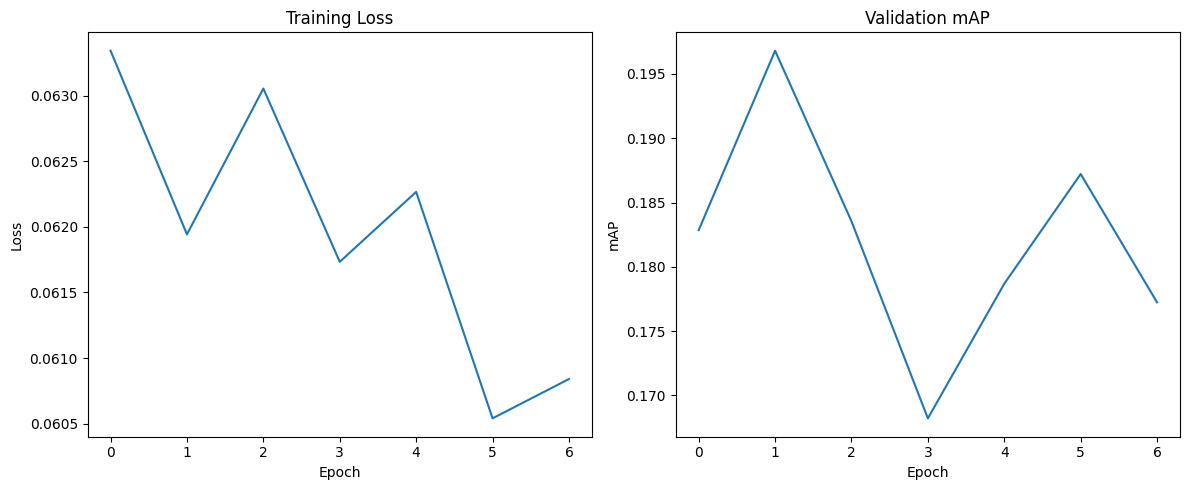

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_maps)
plt.title('Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')

plt.tight_layout()
plt.savefig('training_history.png')

# Final evaluation on test set
print("\nTest Set Evaluation:")
test_map = evaluate(model, test_loader, device)
print(f"Final Test mAP: {test_map:.4f}")

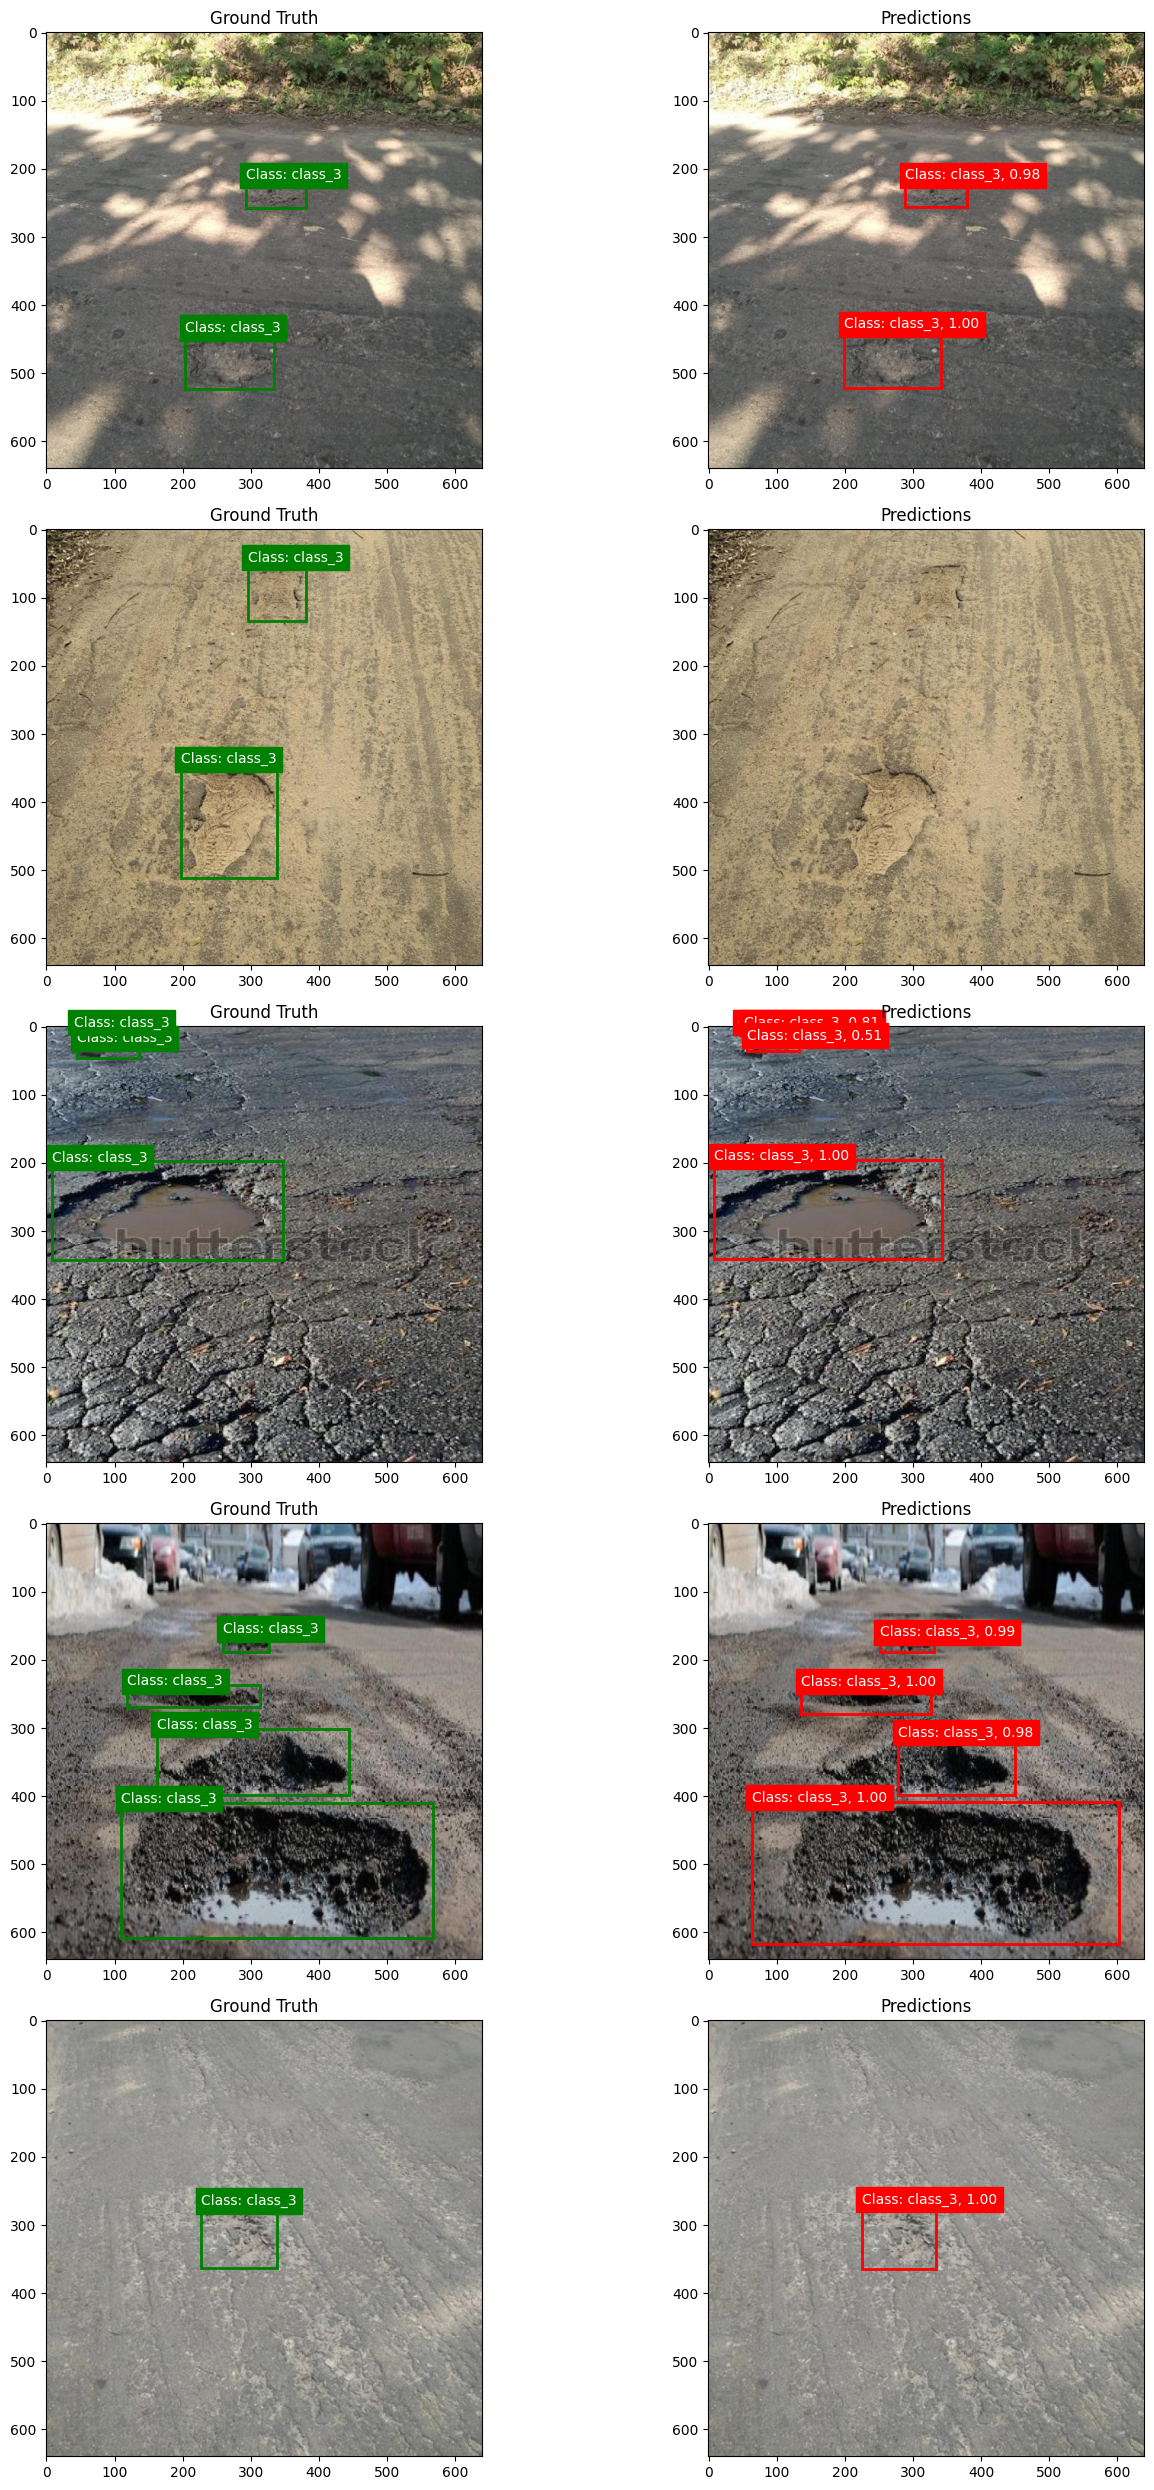

In [ ]:
# Visualize predictions on test set
visualize_predictions(model, test_dataset, device, num_images=5)

## Inference

In [ ]:
def detect_potholes(model, dataset, device, num_images=5, confidence_threshold=0.5):
    """
    Visualize model predictions on random images from the dataset
    """

    LOW_THRESHOLD = 10000
    MEDIUM_THRESHOLD = 40000

    model.eval()
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        # Get random image
        idx = np.random.randint(0, len(dataset))
        img, target = dataset[idx]

        # Get prediction
        with torch.no_grad():
            prediction = model([img.to(device)])[0]

        # Convert image for display
        img = img.permute(1, 2, 0).cpu().numpy()

        # Plot original image with ground truth
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.title("Ground Truth")

        # Draw ground truth boxes
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='green', linewidth=2))

            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            label_item = label.item()
            if 0 <= label_item - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label_item - 1]]['name']  # Use label_item - 1
                plt.text(x1, y1, f"Class: {category_name}", color='white', backgroundcolor='green')
            else:
                print(f"Warning: Label {label_item} out of range for category IDs. Skipping this detection.")

        # Plot image with predictions
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(img)
        plt.title("Predictions")

        # Filter predictions by confidence threshold
        keep = prediction['scores'] > confidence_threshold
        boxes = prediction['boxes'][keep].cpu().numpy()
        labels = prediction['labels'][keep].cpu().numpy()
        scores = prediction['scores'][keep].cpu().numpy()

        # Draw predicted boxes
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                             fill=False, color='red', linewidth=2))
            # Check if label is within bounds of category IDs
            category_ids = dataset.coco.getCatIds()
            if 0 <= label - 1 < len(category_ids):  # Subtract 1 to adjust for 0-based indexing if necessary
                category_name = dataset.coco.cats[category_ids[label - 1]]['name']  # Use label - 1

                #bbox1 = BBox2D( x1, y1, x2, y2)
                bbox1 = BoundingBox.from_xyxy(np.array([x1,y1]), np.array([x2,y2]))
                area = bbox1.height * bbox1.width

                sev_level = 'unknown'
                if area <= LOW_THRESHOLD:
                  sev_level = 'low'
                elif area <= MEDIUM_THRESHOLD:
                  sev_level = 'medium'
                elif area > MEDIUM_THRESHOLD:
                  sev_level = 'high'

                plt.text(x1, y1, f"Severity: {sev_level}, Area: {area:.2f}", color='white', backgroundcolor='red')
            else:
                print(f"Warning: Label {label} out of range for category IDs. Skipping this detection.")

    plt.tight_layout()
    plt.savefig('test_predictions.png')
    plt.show()

In [ ]:
# Load a pre-trained ResNet50 backbone
backbone = torchvision.models.resnet50(pretrained=True)
# Remove the fully connected layer and average pooling layer
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 2048  # ResNet50 has 2048 output channels for the last convolutional layer

# Anchor generator and ROI pooling
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Faster R-CNN model with ResNet50 backbone
fine_tuned_model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
fine_tuned_model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
fine_tuned_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

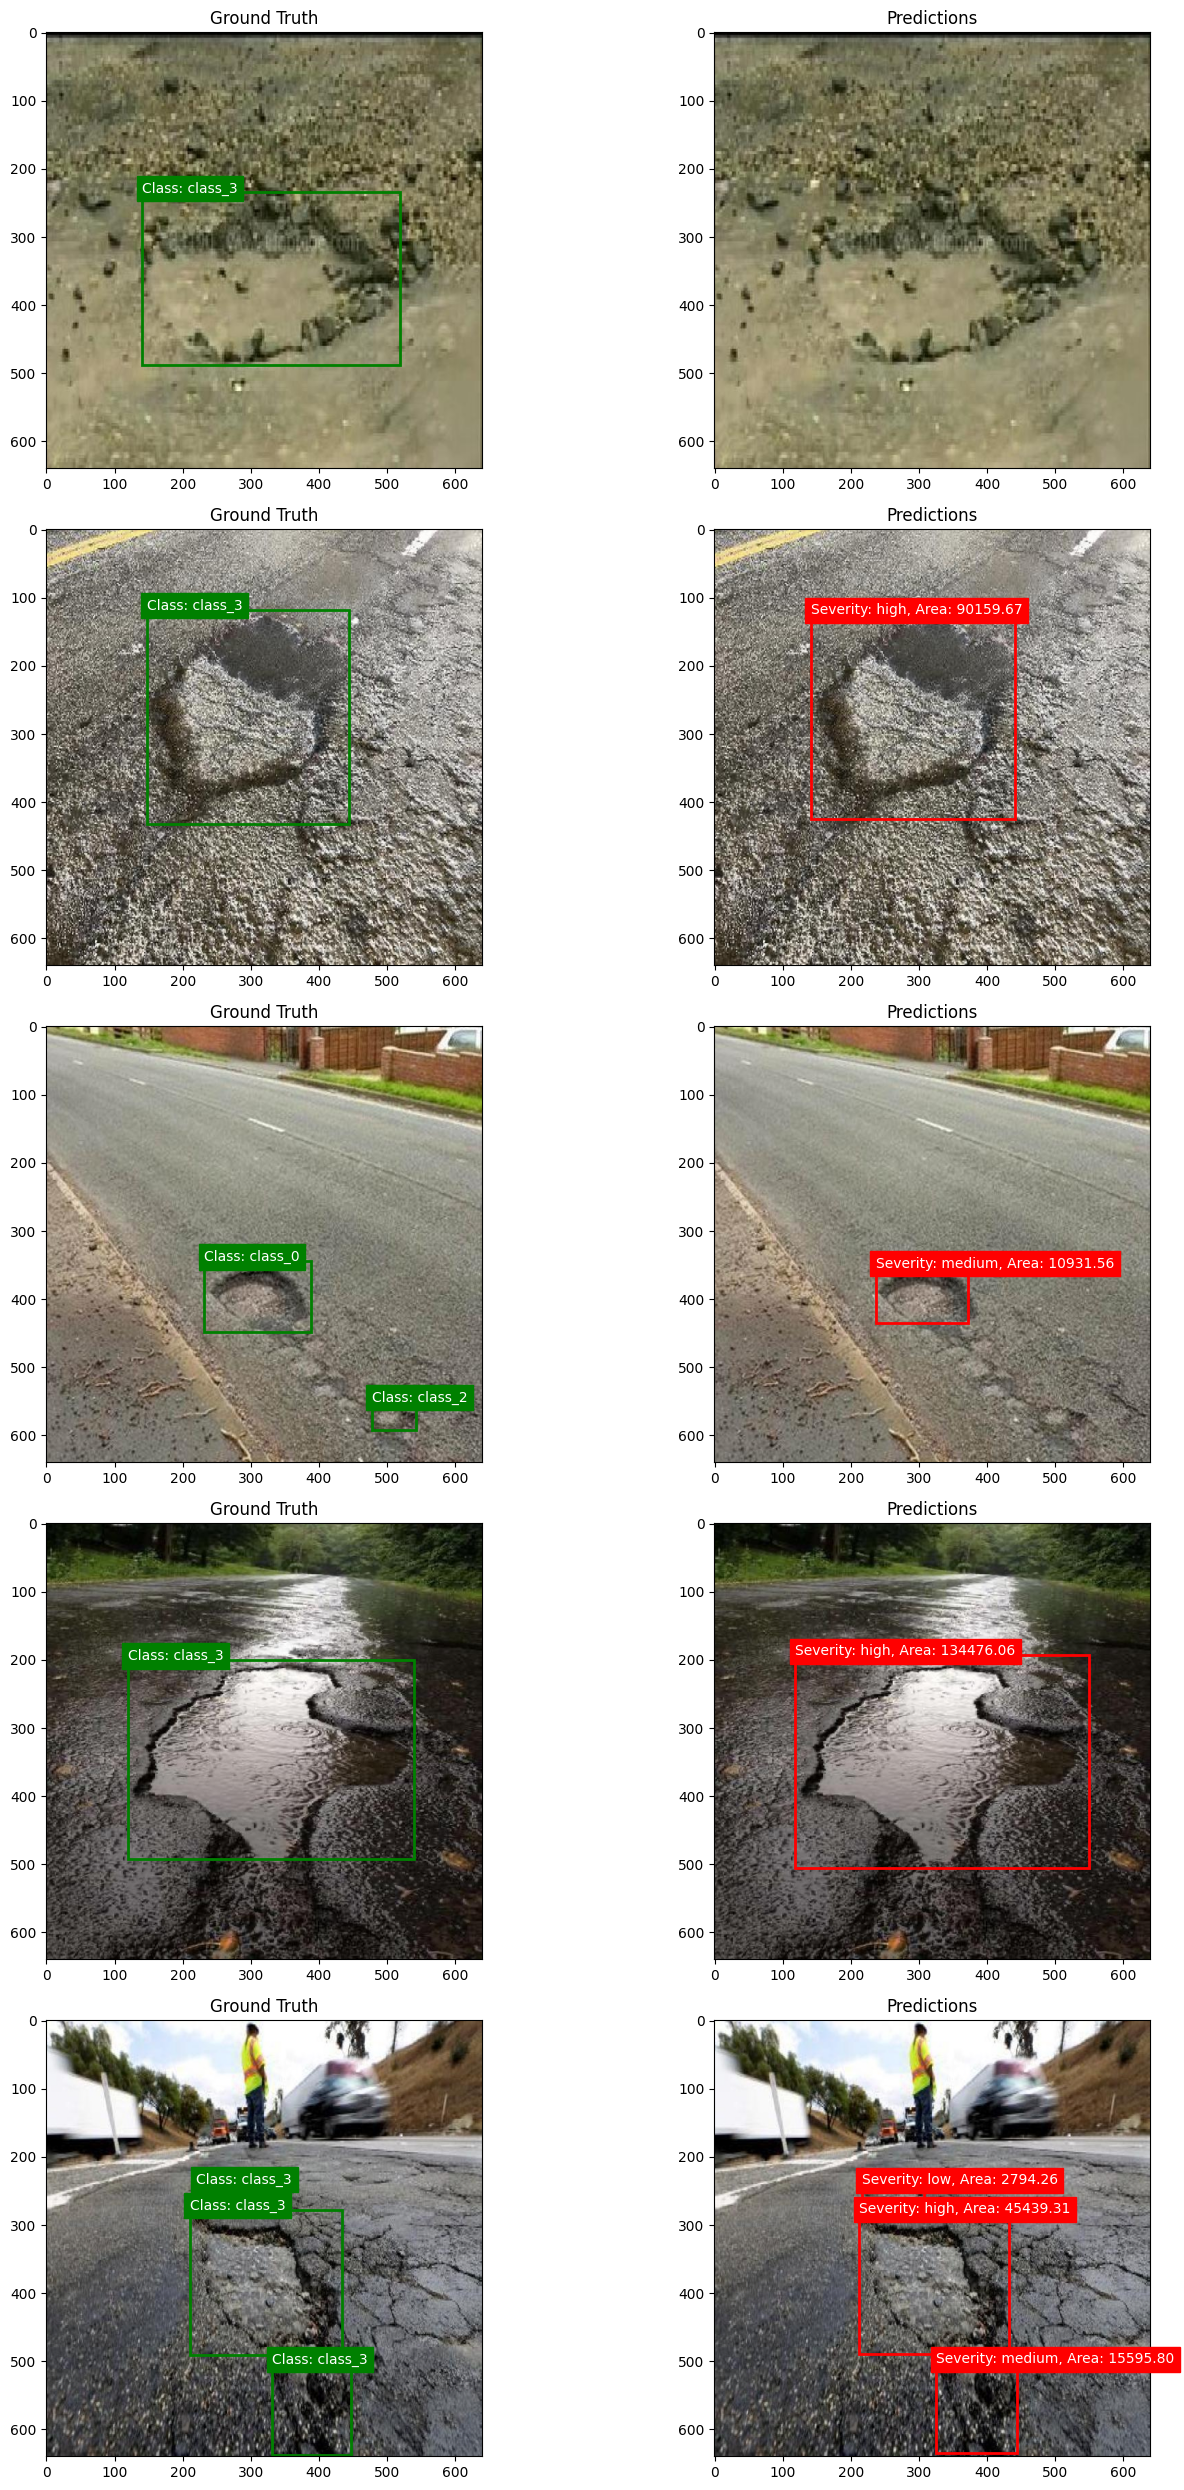

In [ ]:
detect_potholes(fine_tuned_model,test_dataset, device, num_images=5)